# Ratios de Rendimiento Ajustado al Riesgo (Risk-Adjusted Return Ratios)

### Son fundamentales para los inversores que buscan maximizar su rentabilidad mientras gestionan el riesgo. Estas métricas cuantifican la eficiencia con la que se genera rentabilidad por unidad de riesgo, permitiendo comparar diferentes inversiones de manera objetiva. En términos prácticos, ayudan a tomar decisiones de inversión más informadas al mostrar si el riesgo asumido está siendo adecuadamente compensado.

### En la amplia literatura económica financiera encontramos diversos indicadores. En concreto, en este trabajo verémos:

* ### $\text{Sharpe ratio}$
* ### $\text{Sortino ratio}$
* ### $\text{Treynor ratio}$
* ### $\text{Jensen's alpha}$

### En el presente script cálculamos los ratios para los activos individuales y, al final, para la de un portafolio en concreto, tomando la asunción de que cada activo pesa lo mismo en el portafolio.


## Librerías usadas

In [56]:
# Importar librerías para manipulación de datos y análisis estadístico
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm

# Importar librerías para manejo de fechas y descarga de datos financieros
import datetime as dt
import yfinance as yf

# Importar librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importar librerías para optimización de portafolios
from pypfopt.expected_returns import mean_historical_return

# Configuración adicional
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Vemos el comportamiento, rendimiento, y volatilidad de cada activo

[*********************100%***********************]  5 of 5 completed


Ticker            AAPL          BA        MSFT       NVDA        SP500
Date                                                                  
2023-12-22  193.600006  260.440002  374.579987  48.830002  4754.629883
2023-12-26  193.050003  262.790009  374.660004  49.278999  4774.750000
2023-12-27  193.149994  262.100006  374.070007  49.417000  4781.580078
2023-12-28  193.580002  260.350006  375.279999  49.521999  4783.350098
2023-12-29  192.529999  260.660004  376.040009  49.521999  4769.830078
¿Datos faltantes? 
 Ticker
AAPL     0
BA       0
MSFT     0
NVDA     0
SP500    0
dtype: int64


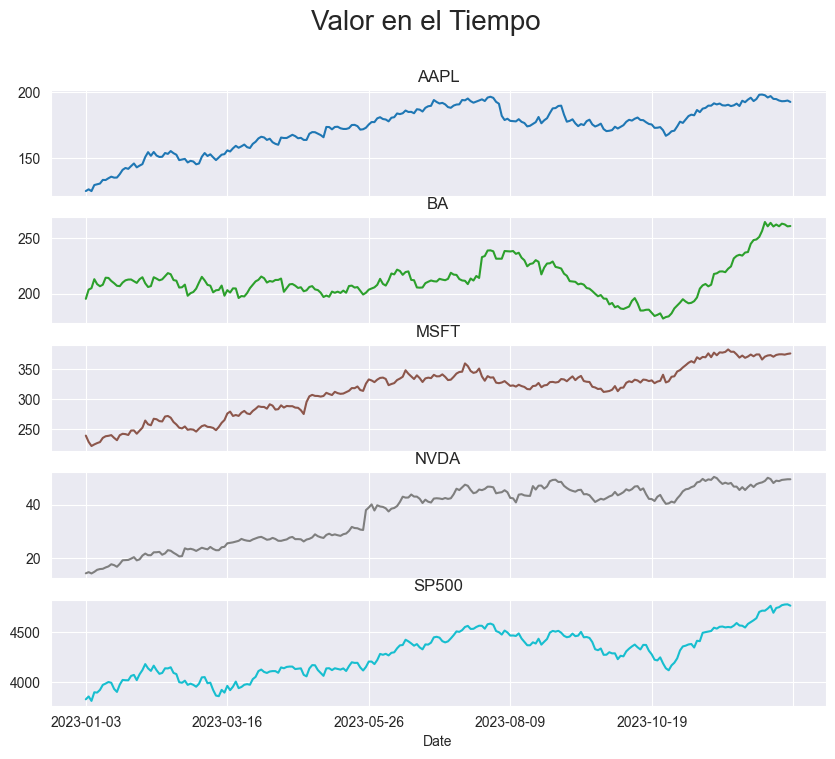

In [57]:
# Establecemos el portafolio y fechas
tickers = ["^GSPC", "AAPL", "BA", "MSFT", "NVDA"]
end = dt.datetime(2024, 1, 1)
start = dt.datetime(2023, 1, 1)

df_raw = yf.download(tickers= tickers, start = start, end= end)

# Reseteamos los índices del dataframe
df_raw.index = df_raw.index.strftime('%Y-%m-%d')

# Vemos los últimos 5 días
df = df_raw["Close"].copy()
df = df.rename(columns= {"^GSPC" : "SP500"})
print(df.tail())
print("="*80)
print("¿Datos faltantes? \n", df.isnull().sum())

# Gráficamos

sns.set_style("darkgrid")
cmap = plt.colormaps.get_cmap('tab10')

fig, ax = plt.subplots(df.shape[1], 1, sharex=True)

for i, column in enumerate(df.columns):
    color = cmap(i / (len(df.columns) - 1))
    df[column].plot(ax=ax[i], kind= "line", color = color)
    ax[i].set_title(column)

fig.suptitle("Valor en el Tiempo", fontsize= 20)
plt.gcf().set_size_inches(10,8)
plt.show()

Log Desviación Estándar anualizados
AAPL     0.198754
BA       0.270071
MSFT     0.249706
NVDA     0.467012
SP500    0.130733
dtype: float64


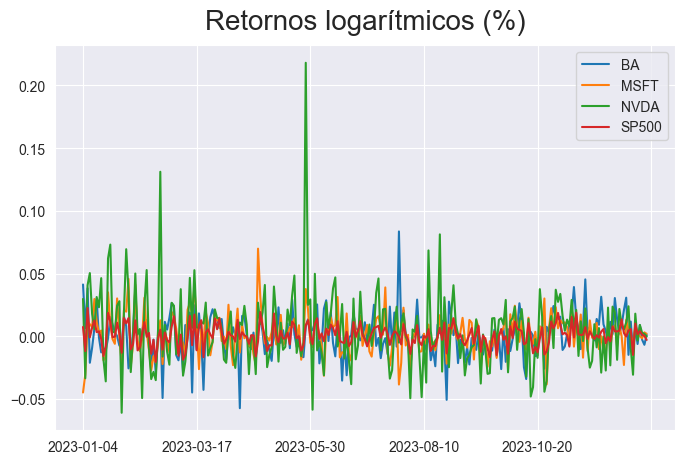

In [58]:
log_returns = pd.DataFrame()

# Un bucle for para itear sobre cada activo y hallar su retoros logaritmicos diarios
for ticker in df:
    log_returns[ticker] = np.log(df[ticker] / df[ticker].shift(1)).dropna()


# Cálculamos las volatilidades anualizadas
daily_volatility  = np.std(log_returns) 
annualized_volatility   = daily_volatility * np.sqrt(252) # se multiplica por la raiz cuadrada del tiempo para anualizar una medida de riesgo, 
#veáse: https://www.ortecfinance.com/en/insights/blog/how-to-correctly-annualize-a-risk-measure

print("Log Desviación Estándar anualizados")
print("=" * 40 )
print(annualized_volatility)

log_returns = pd.DataFrame()

# Un bucle for para itear sobre cada columna del df de la cartera propuesta
for ticker in df:
    log_returns[ticker] = np.log(df[ticker] / df[ticker].shift(1)).dropna()
    
# Gráfiquemos ahora los retornos logarítmicos
log_returns[log_returns.columns[1:]].plot()
plt.gcf().set_size_inches(8, 5)
plt.title("Retornos logarítmicos (%)", fontsize= 20, y = 1.02)
plt.xlabel("")
plt.legend()
plt.show()

## El Sharpe Ratio

### Es una medida que nos dice si una inversión es buena o mala, comparando lo que ganas con el riesgo que tomas. Es como una calificación: si el ratio es alto, significa que estás obteniendo una buena recompensa por el riesgo que estás asumiendo. Imagina que tienes dos opciones de inversión: una que te puede hacer ganar mucho pero también perder mucho, y otra que te garantiza ganar menos pero también perder menos. El ratio de Sharpe te ayuda a elegir la mejor opción, mostrándote cuál te ofrece una mejor relación entre el riesgo y la recompensa.

### Fórmula:

$$\LARGE \text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$$

### Dónde:

### $R_p$: Rentabilidad del activo o portafolio.
### $R_f$: Tasa libre de riesgo.
### $\sigma_p$: Desviación estándar del activo o portafolio.

### Interpretación:

* ### Sharpe Ratio alto: Indica que la inversión ofrece un retorno excedente significativo en relación con el riesgo total asumido.
* ### Sharpe Ratio bajo: Sugiere que el rendimiento no compensa adecuadamente el riesgo asumido.
* ### Sharpe Ratio negativo: Significa que el rendimiento de la inversión es menor que la tasa libre de riesgo.

In [59]:
def sharpe_ratio(returns, log = False, risk_free = 0, market_days = 252):

    # Calculamos el retorno anualizado
    if log:
        annualized_return = returns.mean() * market_days

    else:
        annualized_return = (1 + returns.mean())**market_days - 1
    
    # Calculamos la desviación estándar anualizada
    standard_deviation = returns.std()
                # Devuelve esto si es cero alguno item de la serie
    if (standard_deviation == 0).any():
            return "La desviación estándar no puede ser 0" 
        
    annualized_volatility = standard_deviation * np.sqrt(market_days)

    # Calculamos el índice de Sharpe
    sharpe_ratio = (annualized_return - risk_free) / annualized_volatility

    # Se crea una serie de pandas con el resultado
    sharpe_ratio = pd.Series(sharpe_ratio, name = "sharpe_ratio")

    return sharpe_ratio


In [60]:
# Calculamos el sharpe ratio para cada activo
sharpe_ratios = sharpe_ratio(returns= log_returns, 
                              log= True, 
                              risk_free= 0, 
                              market_days= 252)
print(sharpe_ratios)

AAPL     2.192147
BA       1.077884
MSFT     1.823438
NVDA     2.684167
SP500    1.707222
Name: sharpe_ratio, dtype: float64


## El Sortino Ratio

### El $\text{Sortino Ratio}$ es una métrica de rendimiento ajustado por riesgo, diseñada para evaluar cuánto rendimiento excedente genera un activo o portafolio en comparación con su riesgo de pérdidas o "downside risk". Es una variante del Sharpe Ratio, pero más centrada en la volatilidad negativa.
### Fórmula:
$$\LARGE\text{Sortino Ratio}=\frac{\>R_P - R_f}{\sigma_d}$$
### Dónde:
### $R_p$: Rentabilidad del activo o portafolio.
### $R_f$: Tasa libre de riesgo.
### $\sigma_d$: Medida de la desviación estándar de los rendimientos negativos (es decir, aquellos que están por debajo de la tasa libre de riesgo o del rendimiento objetivo).

### Interpretación:

* ### Sortino Ratio Alto: Buen rendimiento relativo al riesgo negativo.
* ### Sortino Ratio Bajo: Mal balance entre rendimiento y pérdidas potenciales.
* ### Sortino Ratio Negativo: Rendimiento menor que la tasa libre de riesgo, lo cual es desfavorable.



In [61]:
def sortino_ratio(returns, target, market_days=252, log=False):

    # Vémos si se calcula el ratio sobre retornos logarítmicos o no
    if log:
        annualized_return = returns.mean() * market_days
    else:
        annualized_return = (1 + returns.mean())**market_days - 1

    # Se calcula el retorno diario objetivo a días de mercado
    daily_target = (1 + target)**(1 / market_days) - 1

    # Se calcula los retornos negativos o los que están por debajo del retorno objetivo
    negative_returns = returns[returns < daily_target]
    if negative_returns.empty: 
        return print("La desviación estándar es 0")
    
    # Se calcula la desviación estándar de los retornos negativos
    downside_deviation = np.std(negative_returns) * np.sqrt(market_days)
    sortino_ratio = (annualized_return - target) / downside_deviation

    # Se crea una Serie con el resultado
    sortino_ratio = pd.Series(sortino_ratio, name = "sortino_ratio")
    
    return sortino_ratio

In [62]:
sortino_ratios = sortino_ratio(returns= log_returns,
                                target= 0,
                                market_days= 252,
                                  log= True)
sortino_ratios

AAPL     3.513067
BA       1.602140
MSFT     3.135146
NVDA     5.750100
SP500    2.781896
Name: sortino_ratio, dtype: float64

## Treynor Ratio

### El $\text{Treynor Ratio}$ es una medida de rendimiento ajustada por riesgo que evalúa cuánto retorno excedente (por encima de la tasa libre de riesgo) genera una inversión por cada unidad de riesgo sistemático asumido. El riesgo sistemático se mide mediante el beta del activo o portafolio.

### Fórmula:

$$\LARGE \text{Treynor Ratio} = \frac{R_p - R_f}{\beta}$$

### Interpretación:
* ### Ratio alto: Indica que el portafolio o activo genera un buen retorno en relación con el riesgo sistemático asumido.
* ### Ratio bajo o negativo: Sugiere que el rendimiento no compensa adecuadamente el riesgo sistemático.

In [63]:
def treynor_ratio(returns, beta, risk_free = 0, market_days = 252, log = False):
    
    # Vémos si se calcula el ratio sobre retornos logarítmicos o no
    if log:
        annualized_return = returns.mean() * market_days
    else:
        annualized_return = (1 + returns.mean())**market_days - 1

    # Verificar si beta es una Serie o un escalar
    if isinstance(beta, pd.Series):
        # Verificar si hay algún valor es cero
        if (beta == 0).any():
            return print("La beta no puede ser 0")
    else:
        if beta == 0:
            return print("La beta no puede ser 0")

    # Calcular el Sortino Ratio
    treynor_ratio = (annualized_return - risk_free) / beta
    treynor_ratio = pd.Series(treynor_ratio, name = "treynor_ratio")
    
    return treynor_ratio

In [64]:
betas = pd.Series(name= "Beta")
 
for stock in log_returns.columns:
        x = sm.add_constant(log_returns["SP500"])
        models = sm.OLS(endog = log_returns[stock], exog= x).fit()
        results = models.params
        betas[stock] = results[1]

treynor_ratios = treynor_ratio(returns= log_returns,
                                beta= betas,
                                  risk_free= 0,
                                  market_days= 252,
                                  log= True)
treynor_ratios


AAPL     0.396748
BA       0.285496
MSFT     0.388022
NVDA     0.621673
SP500    0.223639
Name: treynor_ratio, dtype: float64

## Jensen's Alpha

### El $\text{alpha de Jensen}$ es una medida de rendimiento ajustada al riesgo que evalúa si un portafolio (o activo) ha generado rendimientos superiores o inferiores a los esperados según el modelo de CAPM (Capital Asset Pricing Model). El CAPM establece el rendimiento teórico esperado de un activo en función de su riesgo sistémico (medido por beta) y el rendimiento del mercado.

$$\LARGE {\alpha} = R_p - [R_f + \beta(R_{m} - R_f)]$$

### Dónde:

### ${R_p}$:  Rendimiento del activo o portafolio.
### ${R_f}$: Tasa libre de riesgo.
### ${R_m}$: Rendimiento del mercado (índice).
### ${\beta}$: Beta del activo o portafolio.

### Interpretación:

* ### ${\alpha}$ > 0: El portafolio supera el rendimiento esperado ajustado por el riesgo; el gestor está generando valor adicional.
* ### ${\alpha}$ = 0: El portafolio cumple exactamente con el rendimiento esperado según su riesgo sistémico.
* ### ${\alpha}$ < 0: El portafolio no alcanza el rendimiento esperado para el nivel de riesgo asumido, indicando bajo desempeño.

In [65]:
def jensen_alpha(returns, market_returns, beta, risk_free = 0, log = False, market_days = 252):

    # Vémos si se calcula el ratio sobre retornos logarítmicos o no
    if log:
        annualized_return = returns.mean() * market_days
        annualized_market_return = market_returns.mean() * market_days
    else:
        annualized_return = (1 + returns.mean())**market_days - 1
        annualized_market_return = (1 + market_returns.mean())**market_days - 1

    # Calcular el Jensen's Alpha
    jensen_alpha = annualized_return - (risk_free + beta * (annualized_market_return - risk_free))
    jensen_alpha = pd.Series(jensen_alpha, name = "jensen_alpha")
    
    return jensen_alpha



In [66]:
jensen_alphas = jensen_alphas = jensen_alpha(returns= log_returns[:-1],
              market_returns= log_returns["SP500"],
              beta= betas,
              risk_free= 0,
              log= True,
              market_days= 252)
print(jensen_alphas)

AAPL     0.197773
BA       0.063166
MSFT     0.193066
NVDA     0.809273
SP500    0.003778
Name: jensen_alpha, dtype: float64


## Vemos todos los ratios calculados en un DataFrame

In [67]:
ratios = pd.concat([sharpe_ratios,
                     sortino_ratios,
                     treynor_ratios,
                       jensen_alphas],
                       axis = 1)[:-1] 
ratios

,sharpe_ratio,sortino_ratio,treynor_ratio,jensen_alpha
AAPL,2.192147,3.513067,0.396748,0.197773
BA,1.077884,1.602140,0.285496,0.063166
MSFT,1.823438,3.135146,0.388022,0.193066
NVDA,2.684167,5.750100,0.621673,0.809273


## Ahora para el portafolio

In [68]:
# creamos un pd.series con el peso de cada activo, que es igual

# Se resta 1 para no incluir el índice S&P 500
# (A no ser que se invierta en un fondo indexado)
weights = np.array([1/(len(tickers) - 1)] * (len(tickers) - 1)) 
print(weights)

[0.25 0.25 0.25 0.25]


In [72]:
portfolio = log_returns.iloc[:, :-1] # Se excluye el SP500
portfolio_returns = portfolio.dot(weights) # Se calcula el retorno del portafolio
portfolio_returns = pd.Series(portfolio_returns, name= "Portfolio") # Se convierte en una Serie

############################################################
# Calculamos los ratios para el portafolio

# sharpe ratio del portafolio
portfolio_sharpe_ratio = sharpe_ratio(returns= portfolio_returns,
                                       log= True,
                                         risk_free= 0)
portfolio_sharpe_ratio.index = ["portfolio_sharpe_ratio"]

# sortino ratio del portafolio
portfolio_sortino_ratio = sortino_ratio(portfolio_returns, target = 0,
                                         market_days= 252,
                                           log= True)
portfolio_sortino_ratio.index = ["portfolio_sortino_ratio"]

# treynor ratio del portafolio
portfolio_treynor_ratio = treynor_ratio(returns = portfolio_returns.mean(),
                                         beta = betas.mean(),
                                           risk_free = 0)
portfolio_treynor_ratio.index = ["portfolio_treynor_ratio"]

# jensen alpha del portafolio
portfolio_jensen_alpha = jensen_alpha(returns= portfolio_returns,
                                        market_returns= log_returns["SP500"],
                                          beta= betas.mean(),
                                            risk_free= 0,
                                              log= True)
portfolio_jensen_alpha.index = ["portfolio_jensen_alpha"]

############################################################
# Concatenamos los ratios en un solo DataFrame
portfolio_ratios = pd.concat([portfolio_sharpe_ratio, portfolio_sortino_ratio,
                               portfolio_treynor_ratio, portfolio_jensen_alpha],
                                 axis= 0,
                                 )
print(portfolio_ratios)

portfolio_sharpe_ratio     2.794805
portfolio_sortino_ratio    5.448541
portfolio_treynor_ratio    0.664205
portfolio_jensen_alpha     0.327536
dtype: float64


### Referencias:

* ### Sharpe, W. F. (1966). Mutual fund performance. Journal of Business, 39(1), 119–138.
* ### Sortino, F. (1994). Performance measurement in a downside risk framework. Journal of Investing, 3(3), 59–65.
* ### Hübner, G. (2003). The generalized Treynor ratio: A note. University of Liege, Management Working Paper. Available at SSRN: https://ssrn.com/abstract=375061 or http://dx.doi.org/10.2139/ssrn.375061
* ### Jensen, M. C. (1967). The performance of mutual funds in the period 1945–1964. Journal of Finance, 23(2), 389–416. Available at SSRN: https://ssrn.com/abstract=244153 or http://dx.doi.org/10.2139/ssrn.244153